In [1]:
import os, sys
import random, h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD

#Initialize the Program
alphabet = "NACGT."
vocab_size = 6
batch_size = 1000
embedding_size = 5
time_steps = 101
category = 2

char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Using TensorFlow backend.


In [2]:
def reverse_complement(sequence):
    retseq = ''
    for k in range(len(sequence)-1, -1, -1):
        if sequence[k] == 'A':
            retseq = retseq + 'T'
        elif sequence[k] == 'T':
            retseq = retseq + 'A'
        elif sequence[k] == 'C':
            retseq = retseq + 'G'
        elif sequence[k] == 'G':
            retseq = retseq + 'C'
        else:
            retseq = retseq + sequence[k]

    """
    print("Revese:")
    print(sequence)
    print(retseq)
    print()
    """
    return retseq


In [3]:
file_read = open("../imgtvgene_sequence_classification/mem.txt")

given_sequence = []
given_cdr3 = []

source_sequence = []
target_sequence = []

cluster_tag = []
cluster_dic = {}
classes = 0

vgene_tag = []
vgene_dic = {}
vgenes = 0

count = 0
max_count = 100000

max_source = 0
max_target = 0

line = file_read.readline()
for line in file_read:
    split = line.strip().split(" ")
    #print(split)
    
    given_sequence.append(split[2][1:-1])
    given_cdr3.append(split[-2][1:-1])
    
    if not split[1] in cluster_dic:
        classes += 1
        cluster_dic[split[1]] = classes
    cluster_tag.append(split[1])
    
    source = [char_to_int[x] for x in split[2][1:-1]]
    source_sequence.append(source)
    if max_source < len(source):
        max_source = len(source)
    
    target = [char_to_int[x] for x in split[-2][1:-1]]
    target_sequence.append(target)
    if max_target < len(target):
        max_target = len(target)
    
    vgene_name = split[-1][1:-1].split("*")[0]
    if not vgene_name in vgene_dic:
        vgene_dic[vgene_name] = vgenes
        vgenes += 1
    vgene_tag.append(vgene_dic[vgene_name])
    
    count += 1
    
    #print(split[1], vgene_name)
    if count == max_count:
        break
    
source_sequence = np.array(source_sequence)
target_sequence = np.array(target_sequence)

cluster_tag = np.array(cluster_tag)
vgene_tag = np.array(vgene_tag)

print(source_sequence.shape, target_sequence.shape)
print(max_source, max_target)
print()
print(cluster_tag.shape, vgene_tag.shape)
print(classes, vgenes)


(100000,) (100000,)
526 201

(100000,) (100000,)
73112 61


# Stop Index Identification

In [4]:
x_data = []
y_data = []
random = []
for k in range(max_count):
    end_ind = given_sequence[k].find(given_cdr3[k]) + len(given_cdr3[k]) - 1
    x_data.append(source_sequence[k][end_ind-10:end_ind+10])
    y_data.append(1)
    
    #random_ind = np.random.randint(low=0, high=st_ind-10, size=None)
    while True:
        random_ind = np.random.randint(low=0, \
                                   high=len(given_sequence[k]), \
                                   size=None)
    
        if not random_ind == end_ind:
            break
        
    x_data.append(source_sequence[k][random_ind-10:random_ind+10])
    y_data.append(0)
    random.append(random_ind)
    
x_data = np.array(x_data)
y_data = np.array(y_data)
random = np.array(random)

In [5]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

x_data = pad_sequences(x_data, maxlen=20, value=0)

train_index = int((len(x_data) / batch_size) * 0.60 * batch_size)
eval_index = train_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
test_index = eval_index + int((len(x_data) / batch_size) * 0.20 * batch_size)
print("train, eval, test = ", (train_index, eval_index, test_index))

x_train = x_data[0:train_index]
y_train = y_data[0:train_index]

x_eval = x_data[train_index:eval_index]
y_eval = y_data[train_index:eval_index]

x_test = x_data[eval_index:test_index]
y_test = y_data[eval_index:test_index]

print(x_train.shape, y_train.shape)
print(x_eval.shape, y_eval.shape)
print(x_test.shape, y_test.shape)

train, eval, test =  (120000, 160000, 200000)
(120000, 20) (120000,)
(40000, 20) (40000,)
(40000, 20) (40000,)


In [6]:
print(x_train[0], y_train[0])
print(x_train[1], y_train[1])
print(random)

[1 2 1 4 3 3 1 2 3 4 2 4 3 3 3 3 2 1 1 1] 1
[1 2 4 2 4 2 1 4 4 2 4 2 2 1 1 4 2 2 4 1] 0
[ 87  39 305 ... 345 292 214]


In [7]:
from keras.layers import Input, Embedding
from keras.layers import Reshape, Dense
from keras.models import Model

input_source = Input(shape=(20,), \
                     dtype='int32', name='main_input')
embedding = Embedding(input_dim=vocab_size, \
                      output_dim=embedding_size, \
                      input_length=20, \
                      name='embedding')(input_source)

reshape_layer = Reshape((20*embedding_size,))(embedding)

dense_layer_first = Dense(64, activation='relu', \
                        name='fstlayer')(reshape_layer)
dense_layer_first = Dropout(0.25)(dense_layer_first)

dense_layer_mid = Dense(32, activation='relu', \
                        name='midlayer')(dense_layer_first)
dense_layer_mid = Dropout(0.25)(dense_layer_mid)

dense_layer = Dense(16, activation='relu', \
                    name='finlayer')(dense_layer_mid)
dense_layer = Dropout(0.25)(dense_layer)

dense_output = Dense(1, activation='sigmoid', \
                     name='output')(dense_layer)#reshape_layer

model = Model(inputs=[input_source], outputs=[dense_output])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 20)                0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 5)             30        
_________________________________________________________________
reshape_1 (Reshape)          (None, 100)               0         
_________________________________________________________________
fstlayer (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
midlayer (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

In [8]:
from keras_tqdm import TQDMNotebookCallback
print('Train...')

history = model.fit(x_train, y_train, \
          validation_data=(x_eval, y_eval), \
          epochs=20, shuffle=True, batch_size=1000, \
           callbacks=[TQDMNotebookCallback()], verbose=2)
score = model.evaluate(x_test, y_test, \
                       batch_size=1000, verbose=2)
print(score)

Train...
Train on 120000 samples, validate on 40000 samples
Epoch 1/20
 - 1s - loss: 0.2346 - acc: 0.9383 - val_loss: 0.0049 - val_acc: 0.9986
Epoch 2/20
 - 1s - loss: 0.0111 - acc: 0.9976 - val_loss: 0.0036 - val_acc: 0.9991
Epoch 3/20
 - 1s - loss: 0.0076 - acc: 0.9984 - val_loss: 0.0033 - val_acc: 0.9993
Epoch 4/20
 - 1s - loss: 0.0062 - acc: 0.9988 - val_loss: 0.0030 - val_acc: 0.9994
Epoch 5/20
 - 1s - loss: 0.0056 - acc: 0.9989 - val_loss: 0.0031 - val_acc: 0.9993
Epoch 6/20
 - 1s - loss: 0.0051 - acc: 0.9991 - val_loss: 0.0030 - val_acc: 0.9995
Epoch 7/20
 - 1s - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0030 - val_acc: 0.9994
Epoch 8/20
 - 1s - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0029 - val_acc: 0.9995
Epoch 9/20
 - 1s - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0031 - val_acc: 0.9994
Epoch 10/20
 - 1s - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0029 - val_acc: 0.9993
Epoch 11/20
 - 1s - loss: 0.0036 - acc: 0.9994 - val_loss: 0.0030 - val_acc: 0.9994
Epoch 12/20
 - 1s - loss:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


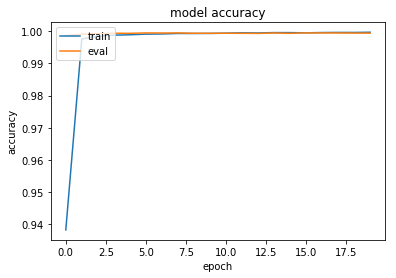

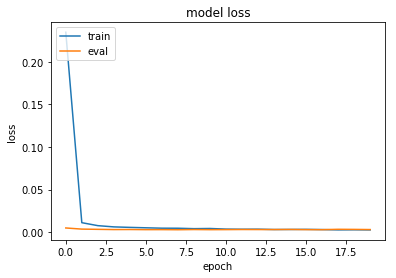

In [9]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'eval'], loc='upper left')
plt.show()

In [57]:
x_data = []
y_data = []
for k in range(max_count):
    end_ind = given_sequence[k].find(given_cdr3[k]) + len(given_cdr3[k]) - 1
    try:
        assert(len(source_sequence[k][end_ind-10:end_ind+10]) == 20)
        x_data.append(source_sequence[k][end_ind-10:end_ind+10])
        y_data.append(1)
    except:
        continue
    
    for i in range(0, 100):
        random_ind = np.random.randint(low=0, \
                                       high=end_ind-1, \
                                       size=None)
        
        if not len(source_sequence[k][random_ind:random_ind+20]) == 20:
            continue
        x_data.append(source_sequence[k][random_ind:random_ind+20])
        y_data.append(0)
        assert(len(x_data[-1]) == 20)
        
    for i in range(0, 5):
        try:
            random_ind = np.random.randint(low=end_ind+1, \
                                       high=len(given_sequence[k])-20, \
                                       size=None)
        except:
            continue
            
        if not len(source_sequence[k][random_ind:random_ind+20]) == 20:
            continue
        x_data.append(source_sequence[k][random_ind:random_ind+20])
        y_data.append(0)
        assert(len(x_data[-1]) == 20)
        


In [61]:
print(len(x_data), len(x_data[0]), len(y_data))
x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape, y_data.shape)

score = model.evaluate(x_data, y_data, \
                       batch_size=1000, verbose=2)
print(score)

10599325 20 10599325
(10599325, 20) (10599325,)
[0.043356684373682376, 0.9969078244923135]


In [62]:
from sklearn.metrics import confusion_matrix, classification_report

y_predict = model.predict(x_data)
print(classification_report(y_true=y_data, y_pred=np.round(y_predict)))
result = [int(y_predict[i] >= 0.50) for i in range(len(y_predict))]
#print(len(result), len(y_test))
print("Accuracy: ", (1.0 * np.sum(np.equal(result, y_data)) / len(y_data)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00  10499331
          1       0.75      1.00      0.86     99994

avg / total       1.00      1.00      1.00  10599325

Accuracy:  0.9969078219603607


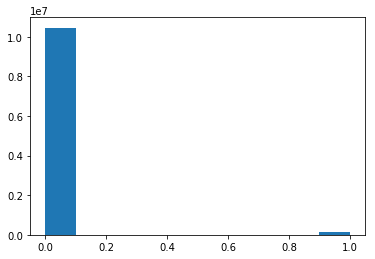

In [63]:
import matplotlib.pyplot as plt
plt.hist(y_predict)
plt.show()